In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

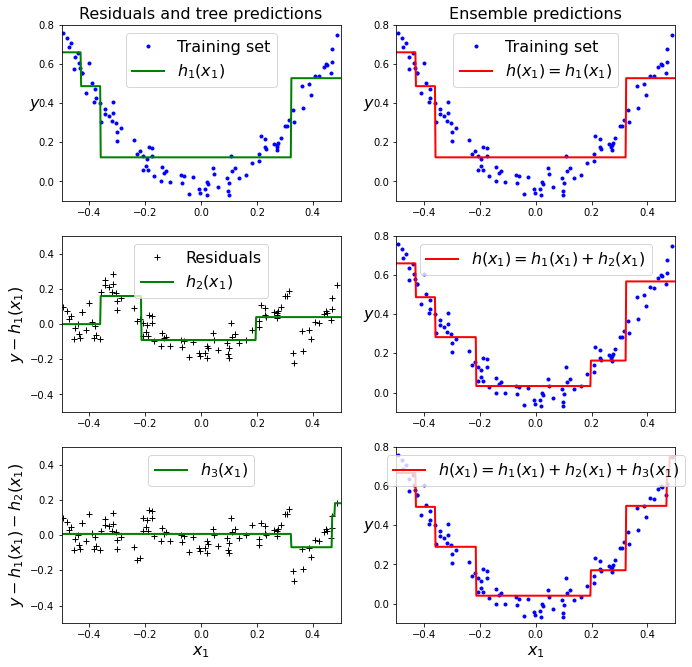

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
df = pd.read_csv('titanic.csv').dropna()

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [11]:
dfo = df.select_dtypes(include=['category', 'object'])

# create a dict with categorical variables and their respective unique counts
levels={}
for col in dfo.columns:
    levels[col] = len(dfo[col].unique())

# print the results as a df
pd.DataFrame.from_dict(levels, orient='index', columns=['Unique_Levels'])

,Unique_Levels
Name,183
Sex,2
Ticket,127
Cabin,133
Embarked,3


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [12]:
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(183, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [13]:
df.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [14]:
X = df.drop('Survived', axis = 1)
y = df.Survived

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [15]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify = y)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [17]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, 
                                    max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.737
Accuracy score (validation): 0.717

Learning rate:  0.1
Accuracy score (training): 0.818
Accuracy score (validation): 0.804

Learning rate:  0.25
Accuracy score (training): 0.847
Accuracy score (validation): 0.739

Learning rate:  0.5
Accuracy score (training): 0.898
Accuracy score (validation): 0.783

Learning rate:  0.75
Accuracy score (training): 0.891
Accuracy score (validation): 0.804

Learning rate:  1
Accuracy score (training): 0.883
Accuracy score (validation): 0.804



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

There are three learning rate values that achieved the best accuracy on the validation set. We will choose the one with the lower score on the training set, as it indicates a model with less overfitting. Based on the above results, `the best learning rate is 0.1.`

In [18]:
# initialize the object learning rate = 0.1
gb = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth = 2, random_state = 0)

# fit the BGM
gb.fit(X_train, y_train)

# predict on the test set
y_pred = gb.predict(X_test)

<font color='teal'>**Confusion Matrix:**</font>

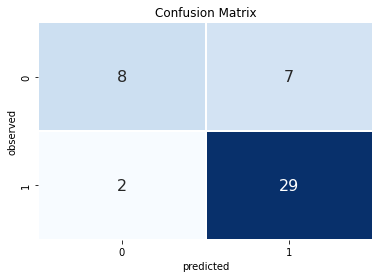

In [19]:
# display the confusion matrix using sns heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidths=.2,
            cmap='Blues', 
            cbar=False,
            annot_kws={"size": 16}
           )

# add title and labels
plt.title('Confusion Matrix')
plt.xlabel('predicted')
plt.ylabel('observed')
plt.show();

Model is predicting: 
<li>29 True Positives, 
<li>8 True Negatives, 
<li>7 False Negatives, 
<li>2 False Positives

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.81      0.94      0.87        31

    accuracy                           0.80        46
   macro avg       0.80      0.73      0.75        46
weighted avg       0.80      0.80      0.79        46



The model is demonstrating very good performance in correctly identifying category 1. <br> However, for category 0 is not performing very well, this poor result could partly be attributed to the class imbalance, with 15 data points in category 0 and 31 datapoints in category 1, for the choosen training sample.

In [21]:
# An important insight we need to look into is the distribution of 1 and 0 classes for the target variable:
print(f"Class 1 distribution = {df.Survived.value_counts(normalize=True)[1].round(2) *100} % of the datapoints")
print(f"Class 0 distribution = {df.Survived.value_counts(normalize=True)[0].round(2) *100} % of the datapoints")

Class 1 distribution = 67.0 % of the datapoints
Class 0 distribution = 33.0 % of the datapoints


About 67% of the datapoints have the target value of class 1 and about 33% of class 0. <br>If we were to predict class 1 all the time we would get a 67% acuracy.<br>
The accuracty is not the best metric to evaluate this model, precision, recall, F1-score, and the confusion matrix helps us getting a better understanding on the performance of the model on both classes


We should plot  the ROC curve to assess performance on positive class

**<font color='teal'>Calculate the ROC for the model as well.</font>**

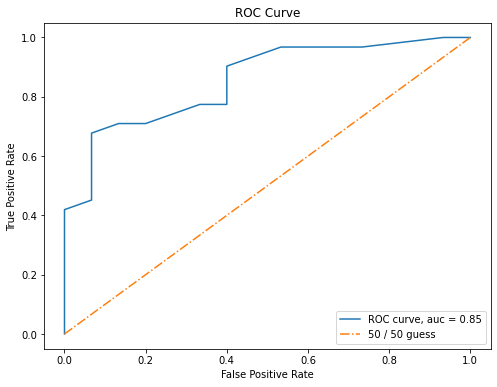

In [22]:
# probability for each prediction
y_prob = gb.predict_proba(X_test)

# calculate roc_curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob[:,1])

# calculate the auc
roc_auc = auc(false_positive_rate, true_positive_rate)

# plot the curve
plt.figure(figsize=(8,6))
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve, auc = '+str(round(roc_auc,2)))
plt.plot([0,1],[0,1], linestyle="-.", label="50 / 50 guess")

# labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show();

The ROC curve visualizes the trade-off between the True Positive Rate and the False Positive Rate (FPR). The value of Area Under the Curve is 0.85, indicating that the model is doing better predicting category 1 then just choosing by random chance (50/50, auc = 0.5)